In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.feature_selection import RFECV, chi2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from tensorflow.keras.models import load_model

import autokeras as ak

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

print('Tensorflow Using GPU: {}'.format(tf.test.is_gpu_available()))
print('TensorFlow version: {}'.format(tf.__version__))
print('Which device could I use: {}'.format(tf.config.list_physical_devices()))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Tensorflow Using GPU: True
TensorFlow version: 2.4.2
Which device could I use: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Info

## Train Data

In [2]:
train_data = pd.read_csv('/workspace/adam/tfx/titanic/train/train.csv')
train_data.head(15)

PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10         1       2   
10           11         1       3   
11           12         1       1   
12           13         0       3   
13           14         0       3   
14           15         0       3   

                                                 Name     Sex   Age  SibSp  \
0                             Braund, Mr. Owen Harris    male  22.0      1   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                              Heikkinen, Miss. Laina  female  26.0      0   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                            Allen, Mr. William Henry    male  35.0      0   
5                                    Moran, Mr. James    male   NaN      0   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
7                      Palsson, Master. Gosta Leonard    male   2.0      3   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                 Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   
12                     Saundercock, Mr. William Henry    male  20.0      0   
13                        Andersson, Mr. Anders Johan    male  39.0      1   
14               Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   

    Parch            Ticket     Fare Cabin Embarked  
0       0         A/5 21171   7.2500   NaN        S  
1       0          PC 17599  71.2833   C85        C  
2       0  STON/O2. 3101282   7.9250   NaN        S  
3       0            113803  53.1000  C123        S  
4       0            373450   8.0500   NaN        S  
5       0            330877   8.4583   NaN        Q  
6       0             17463  51.8625   E46        S  
7       1            349909  21.0750   NaN        S  
8       2            347742  11.1333   NaN        S  
9       0            237736  30.0708   NaN        C  
10      1           PP 9549  16.7000    G6        S  
11      0            113783  26.5500  C103        S  
12      0         A/5. 2151   8.0500   NaN        S  
13      5            347082  31.2750   NaN        S  
14      0            350406   7.8542   NaN        S

In [3]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Test Data

In [5]:
test_data = pd.read_csv('/workspace/adam/tfx/titanic/test/test.csv')
test_data['Name'] = test_data.Name.str.replace('"', '')
test_data.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [6]:
ground_truth = pd.read_csv('/workspace/adam/tfx/titanic/test/test_truth.csv')
ground_truth['name'] = ground_truth.name.str.replace('"', '')
survived = []
for t_idx in range(len(test_data)):
#     print(ground_truth.loc[(ground_truth['name']==test_data.iloc[t_idx]['Name']) & (ground_truth['ticket']==test_data.iloc[t_idx]['Ticket']), 'survived'].values[0])
    survived.append(ground_truth.loc[(ground_truth['name']==test_data.iloc[t_idx]['Name']) & 
                                     (ground_truth['ticket']==test_data.iloc[t_idx]['Ticket']), 'survived'].values[0])
test_data['Survived'] = survived
display(test_data)

PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  \
0      male  34.5      0      0              330911    7.8292   NaN        Q   
1    female  47.0      1      0              363272    7.0000   NaN        S   
2      male  62.0      0      0              240276    9.6875   NaN        Q   
3      male  27.0      0      0              315154    8.6625   NaN        S   
4    female  22.0      1      1             3101298   12.2875   NaN        S   
..      ...   ...    ...    ...                 ...       ...   ...      ...   
413    male   NaN      0      0           A.5. 3236    8.0500   NaN        S   
414  female  39.0      0      0            PC 17758  108.9000  C105        C   
415    male  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S   
416    male   NaN      0      0              359309    8.0500   NaN        S   
417    male   NaN      1      1                2668   22.3583   NaN        C   

     Survived  
0           0  
1           1  
2           0  
3           0  
4           1  
..        ...  
413         0  
414         1  
415         0  
416         0  
417         1  

[418 rows x 12 columns]

In [7]:
test_data.describe()

PassengerId      Pclass         Age       SibSp       Parch  \
count   418.000000  418.000000  332.000000  418.000000  418.000000   
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   
std     120.810458    0.841838   14.181209    0.896760    0.981429   
min     892.000000    1.000000    0.170000    0.000000    0.000000   
25%     996.250000    1.000000   21.000000    0.000000    0.000000   
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   
max    1309.000000    3.000000   76.000000    8.000000    9.000000   

             Fare    Survived  
count  417.000000  418.000000  
mean    35.627188    0.377990  
std     55.907576    0.485466  
min      0.000000    0.000000  
25%      7.895800    0.000000  
50%     14.454200    0.000000  
75%     31.500000    1.000000  
max    512.329200    1.000000

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Survived     418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


# Append All Data

In [9]:
data = train_data.append(test_data).reset_index()
data

index  PassengerId  Survived  Pclass  \
0         0            1         0       3   
1         1            2         1       1   
2         2            3         1       3   
3         3            4         1       1   
4         4            5         0       3   
...     ...          ...       ...     ...   
1304    413         1305         0       3   
1305    414         1306         1       1   
1306    415         1307         0       3   
1307    416         1308         0       3   
1308    417         1309         1       3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                                 ...     ...   ...    ...   
1304                                 Spector, Mr. Woolf    male   NaN      0   
1305                       Oliva y Ocana, Dona. Fermina  female  39.0      0   
1306                       Saether, Mr. Simon Sivertsen    male  38.5      0   
1307                                Ware, Mr. Frederick    male   NaN      0   
1308                           Peter, Master. Michael J    male   NaN      1   

      Parch              Ticket      Fare Cabin Embarked  
0         0           A/5 21171    7.2500   NaN        S  
1         0            PC 17599   71.2833   C85        C  
2         0    STON/O2. 3101282    7.9250   NaN        S  
3         0              113803   53.1000  C123        S  
4         0              373450    8.0500   NaN        S  
...     ...                 ...       ...   ...      ...  
1304      0           A.5. 3236    8.0500   NaN        S  
1305      0            PC 17758  108.9000  C105        C  
1306      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
1307      0              359309    8.0500   NaN        S  
1308      1                2668   22.3583   NaN        C  

[1309 rows x 13 columns]

Sex  Survived
0  female    0.7420
1    male    0.1889

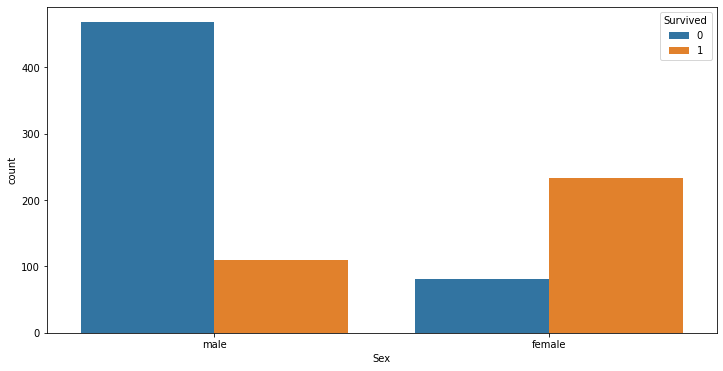

In [10]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().round(4))
sns.countplot(x=train_data['Sex'], hue=train_data['Survived'], ax=ax1)
plt.show()

Embarked  Survived
0        C    0.5536
1        Q    0.3896
2        S    0.3370

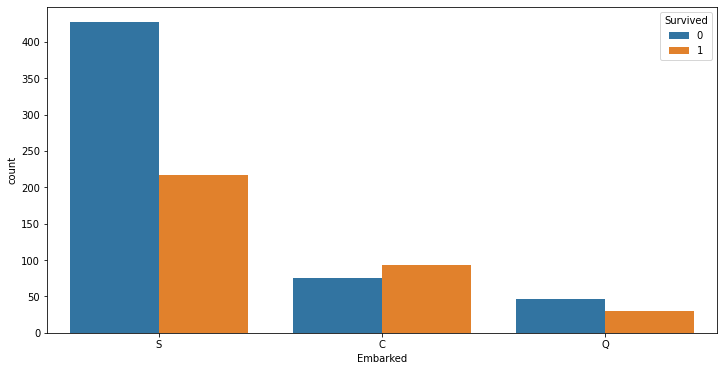

In [11]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().round(4))
sns.countplot(x=train_data['Embarked'], hue=train_data['Survived'], ax=ax1)
plt.show()

Pclass  Survived
0       1    0.6296
1       2    0.4728
2       3    0.2424

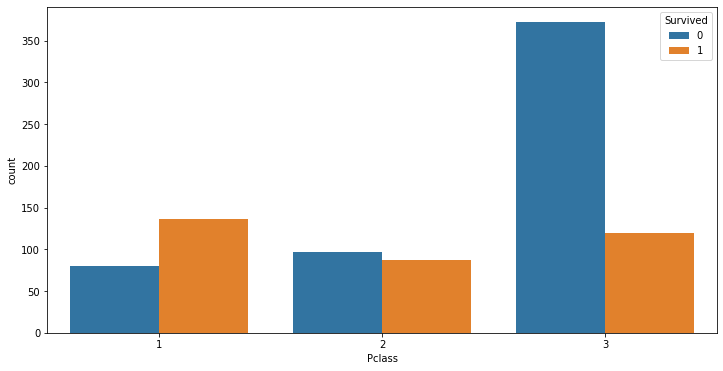

In [12]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().round(4))
sns.countplot(x=train_data['Pclass'], hue=train_data['Survived'], ax=ax1)
plt.show()

Age  Survived
0    0.42       1.0
1    0.67       1.0
2    0.75       1.0
3    0.83       1.0
4    0.92       1.0
..    ...       ...
83  70.00       0.0
84  70.50       0.0
85  71.00       0.0
86  74.00       0.0
87  80.00       1.0

[88 rows x 2 columns]

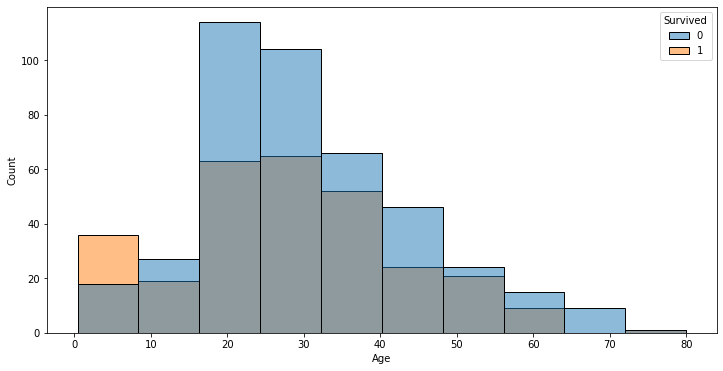

In [13]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(train_data[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().round(4))
sns.histplot(x=train_data['Age'], hue=train_data['Survived'], bins=10, ax=ax1)
plt.show()

Fare  Survived
0      0.0000    0.0667
1      4.0125    0.0000
2      5.0000    0.0000
3      6.2375    0.0000
4      6.4375    0.0000
..        ...       ...
243  227.5250    0.7500
244  247.5208    0.5000
245  262.3750    1.0000
246  263.0000    0.5000
247  512.3292    1.0000

[248 rows x 2 columns]

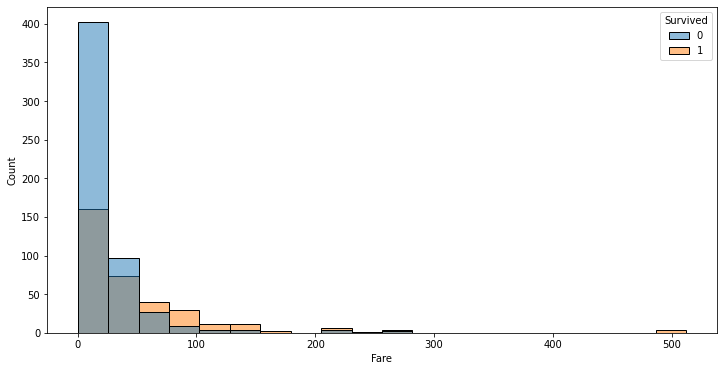

In [14]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(train_data[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().round(4))
sns.histplot(x=train_data['Fare'], hue=train_data['Survived'], bins=20, ax=ax1)
plt.show()

Family_Size  Survived
0            1    0.3025
1            2    0.5362
2            3    0.5660
3            4    0.6977
4            5    0.2727
5            6    0.2000
6            7    0.2500
7            8    0.0000
8           11    0.0000

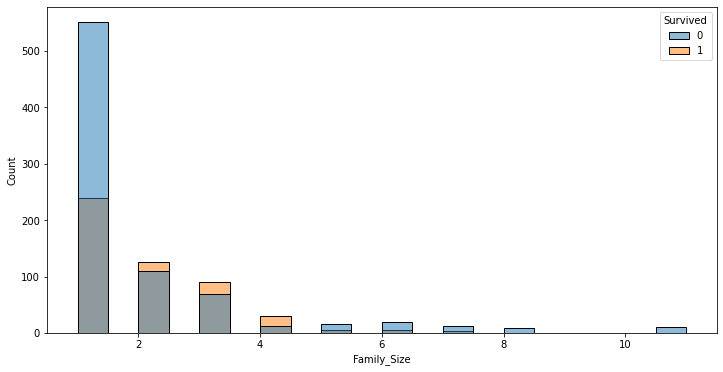

In [15]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
data['Family_Size'] = data['SibSp']+data['Parch']+1
display(data[['Family_Size', 'Survived']].groupby(['Family_Size'], as_index=False).mean().round(4))
sns.histplot(x=data['Family_Size'], hue=data['Survived'], bins=20, ax=ax1)
plt.show()

Embarked  Survived
0        C    0.5556
1        Q    0.3577
2        S    0.3326

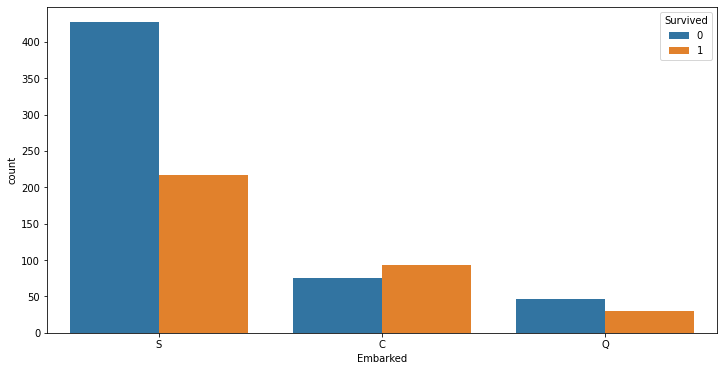

In [16]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().round(4))
sns.countplot(x=train_data['Embarked'], hue=train_data['Survived'], ax=ax1)
plt.show()

Has_Age  Survived
0        0    0.2776
1        1    0.4082

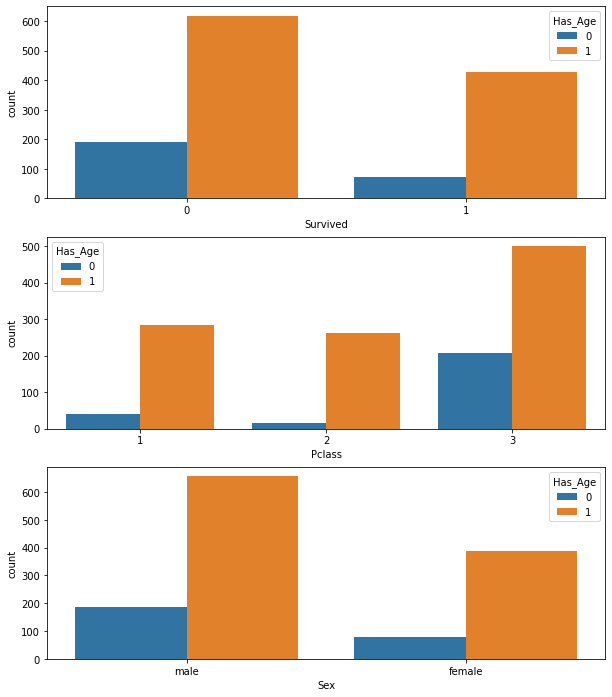

In [17]:
fig = plt.figure(figsize=(6,12))
fig.set_figwidth(10)
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
           
data['Has_Age'] = data['Age'].isnull().map(lambda x : 0 if x == True else 1)
display(data[['Has_Age', 'Survived']].groupby(['Has_Age'], as_index=False).mean().round(4))
sns.countplot(x=data['Survived'], hue=data['Has_Age'], ax=ax1)
sns.countplot(x=data['Pclass'], hue=data['Has_Age'], ax=ax2)
sns.countplot(x=data['Sex'], hue=data['Has_Age'], ax=ax3)

plt.show()

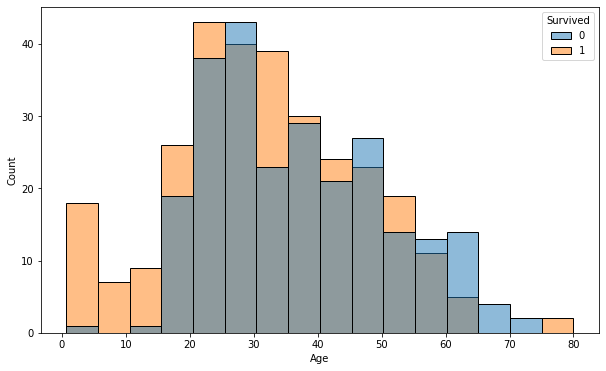

In [18]:
fig = plt.figure(figsize=(12,6))
fig.set_figwidth(10)
ax1 = fig.add_subplot(1,1,1)
           
data['Has_Age'] = data['Age'].isnull().map(lambda x : 0 if x == True else 1)
pclass_12_has_age = data.loc[(data['Pclass'] != 3) & (data['Has_Age'] == 1)]
# display(pclass_12_has_age[['Has_Age', 'Survived']].groupby(['Has_Age'], as_index=False).mean().round(4))
sns.histplot(x=pclass_12_has_age['Age'], hue=pclass_12_has_age['Survived'], ax=ax1)
plt.show()

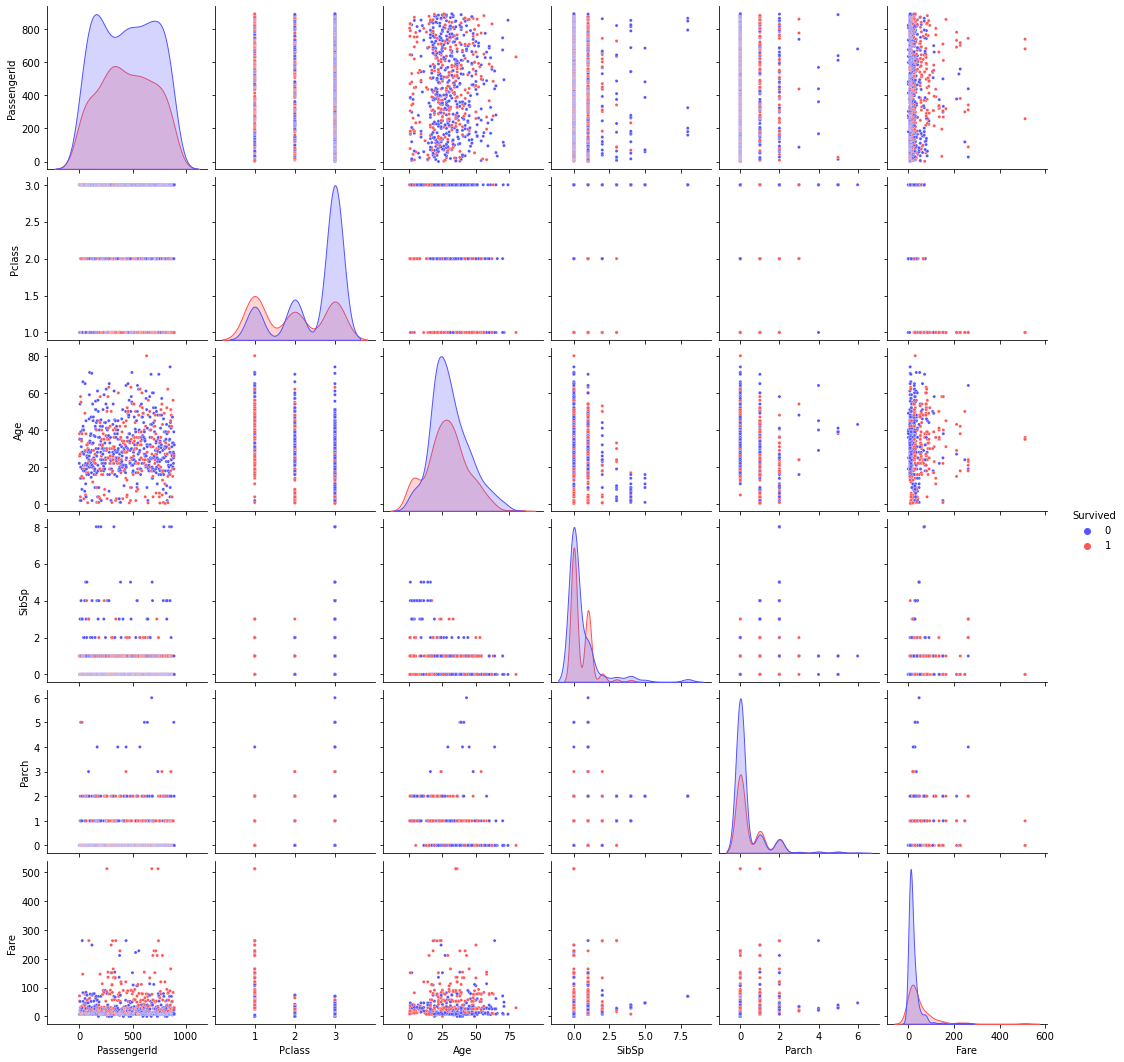

In [19]:
g = sns.pairplot(data=train_data, hue='Survived', palette = 'seismic',
                 height=2.5,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )

# Feature Selection

## Fare

In [20]:
data['Fare_4'] = pd.qcut(data['Fare'], 4).values
le = LabelEncoder()
data['Fare_4'] = le.fit_transform(data['Fare_4'])

data['Fare_5'] = pd.qcut(data['Fare'], 5).values
le = LabelEncoder()
data['Fare_5'] = LabelEncoder().fit_transform(data['Fare_5'])

data['Fare_6'] = pd.qcut(data['Fare'], 6).values
le = LabelEncoder()
data['Fare_6'] = LabelEncoder().fit_transform(data['Fare_6'])

display(data[['Fare_4', 'Survived']].groupby(['Fare_4'], as_index=False).mean().round(4))
display(data[['Fare_5', 'Survived']].groupby(['Fare_5'], as_index=False).mean().round(4))
display(data[['Fare_6', 'Survived']].groupby(['Fare_6'], as_index=False).mean().round(4))

X = data[['Pclass', 'Fare_4', 'Fare_5', 'Fare_6']].values[:len(train_data)]
y = data['Survived'].values[:len(train_data)]
clf = RandomForestClassifier()
selector = RFECV(clf, cv=10, n_jobs=-1)
selector = selector.fit(X, y)

print('')
print('selector.support_:', selector.support_)
print('selector.ranking_:', selector.ranking_)
print('selector.grid_scores_:', selector.grid_scores_)

Fare_4  Survived
0       0    0.2285
1       1    0.2844
2       2    0.4360
3       3    0.5851
4       4    0.0000

Fare_5  Survived
0       0    0.2582
1       1    0.2008
2       2    0.3798
3       3    0.4580
4       4    0.6178
5       5    0.0000

Fare_6  Survived
0       0    0.2458
1       1    0.1927
2       2    0.3350
3       3    0.4133
4       4    0.4528
5       5    0.6682
6       6    0.0000


selector.support_: [ True False False  True]
selector.ranking_: [1 3 2 1]
selector.grid_scores_: [0.67797753 0.70153558 0.69143571 0.70043695]


score_4: [0.6970162297128589, 0.6857428214731586, 0.7014731585518102, 0.6935955056179774, 0.7014856429463171, 0.6867915106117353, 0.7003370786516854, 0.6970661672908863, 0.693645443196005, 0.7014856429463172]
score_5: [0.6959300873907616, 0.6902621722846443, 0.6936204744069913, 0.6936079900124843, 0.6992134831460675, 0.6834207240948815, 0.6958302122347066, 0.6891885143570536, 0.6925218476903872, 0.6947315855181024]
score_6: [0.7037827715355804, 0.7003620474406992, 0.7037453183520598, 0.7059675405742821, 0.7093008739076155, 0.7036079900124845, 0.7036953807740324, 0.699250936329588, 0.7003870162297129, 0.7104369538077403]


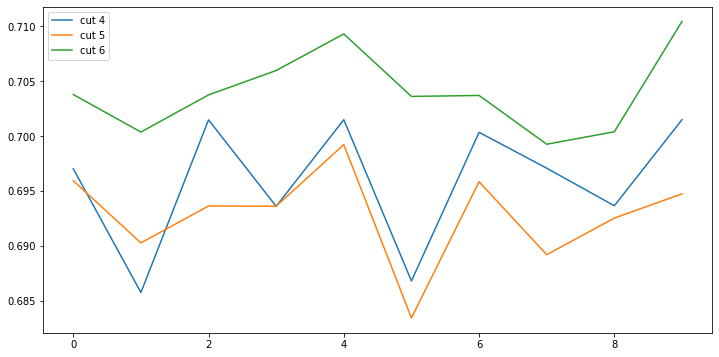

In [21]:
score_4 = []
score_5 = []
score_6 = []

seed = 10
X = data[['Pclass', 'Fare_4', 'Fare_5', 'Fare_6']].values[:len(train_data)]
y = data['Survived'].values[:len(train_data)]
for i in range(seed):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    clf = RandomForestClassifier()
    selector = RFECV(clf, cv=skf, n_jobs=-1)
    selector = selector.fit(X, y)
    score_4.append(selector.grid_scores_[1])
    score_5.append(selector.grid_scores_[2])    
    score_6.append(selector.grid_scores_[3])
print('score_4:', score_4)
print('score_5:', score_5)
print('score_6:', score_6)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot(score_4, label='cut 4')
ax.plot(score_5, label='cut 5')
ax.plot(score_6, label='cut 6')
ax.legend()
plt.show()

## Connected

In [22]:
unique, counts = np.unique(data['Ticket'].values, return_counts=True)
all_cou = 0
for cou in counts:
    if cou != 1:
        all_cou+=cou
print('有共同票根的人數有：', all_cou)

有共同票根的人數有： 596


In [23]:
data['Connected_Survival'] = 0.5
unique, counts = np.unique(data['Ticket'].values, return_counts=True)

for ticket, cou in zip(unique, counts):
    if cou > 1:
        s_max = data.loc[data['Ticket'] == ticket, 'Survived'].max()
        s_min = data.loc[data['Ticket'] == ticket, 'Survived'].min()
        if s_max == 1.0:
            data.loc[data['Ticket'] == ticket, 'Connected_Survival'] = 1.0
        elif s_min == 0.0:
            data.loc[data['Ticket'] == ticket, 'Connected_Survival'] = 0.0
display(data.head(20))
display(data.groupby('Connected_Survival')[['Survived']].mean().round(4))

index  PassengerId  Survived  Pclass  \
0       0            1         0       3   
1       1            2         1       1   
2       2            3         1       3   
3       3            4         1       1   
4       4            5         0       3   
5       5            6         0       3   
6       6            7         0       1   
7       7            8         0       3   
8       8            9         1       3   
9       9           10         1       2   
10     10           11         1       3   
11     11           12         1       1   
12     12           13         0       3   
13     13           14         0       3   
14     14           15         0       3   
15     15           16         1       2   
16     16           17         0       3   
17     17           18         1       2   
18     18           19         0       3   
19     19           20         1       3   

                                                 Name     Sex   Age  SibSp  \
0                             Braund, Mr. Owen Harris    male  22.0      1   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                              Heikkinen, Miss. Laina  female  26.0      0   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                            Allen, Mr. William Henry    male  35.0      0   
5                                    Moran, Mr. James    male   NaN      0   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
7                      Palsson, Master. Gosta Leonard    male   2.0      3   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                 Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   
12                     Saundercock, Mr. William Henry    male  20.0      0   
13                        Andersson, Mr. Anders Johan    male  39.0      1   
14               Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   
15                   Hewlett, Mrs. (Mary D Kingcome)   female  55.0      0   
16                               Rice, Master. Eugene    male   2.0      4   
17                       Williams, Mr. Charles Eugene    male   NaN      0   
18  Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0      1   
19                            Masselmani, Mrs. Fatima  female   NaN      0   

    Parch            Ticket     Fare Cabin Embarked  Family_Size  Has_Age  \
0       0         A/5 21171   7.2500   NaN        S            2        1   
1       0          PC 17599  71.2833   C85        C            2        1   
2       0  STON/O2. 3101282   7.9250   NaN        S            1        1   
3       0            113803  53.1000  C123        S            2        1   
4       0            373450   8.0500   NaN        S            1        1   
5       0            330877   8.4583   NaN        Q            1        0   
6       0             17463  51.8625   E46        S            1        1   
7       1            349909  21.0750   NaN        S            5        1   
8       2            347742  11.1333   NaN        S            3        1   
9       0            237736  30.0708   NaN        C            2        1   
10      1           PP 9549  16.7000    G6        S            3        1   
11      0            113783  26.5500  C103        S            1        1   
12      0         A/5. 2151   8.0500   NaN        S            1        1   
13      5            347082  31.2750   NaN        S            7        1   
14      0            350406   7.8542   NaN        S            1        1   
15      0            248706  16.0000   NaN        S            1        1   
16      1            382652  29.1250   NaN        Q            6        1   
17      0            244373  13.0000   NaN        S   

Survived
Connected_Survival          
0.0                   0.0000
0.5                   0.2721
1.0                   0.7463

Title
Master     4
Miss      22
Mr        29
Mrs       35
Rare      49
Royal     39
Name: Age, dtype: int64

Title  Survived
0  Master    0.5082
1    Miss    0.6792
2      Mr    0.1625
3     Mrs    0.7868
4    Rare    0.3043
5   Royal    0.6667

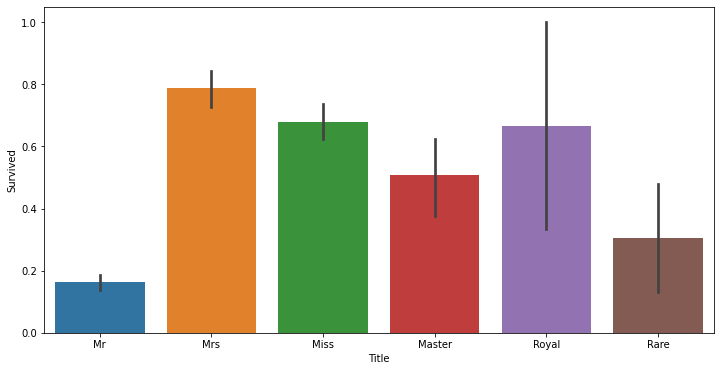

Master  Miss  Mr  Mrs  Rare  Royal
0          0     0   1    0     0      0
1          0     0   0    1     0      0
2          0     1   0    0     0      0
3          0     0   0    1     0      0
4          0     0   1    0     0      0
...      ...   ...  ..  ...   ...    ...
1304       0     0   1    0     0      0
1305       0     0   0    0     0      1
1306       0     0   1    0     0      0
1307       0     0   1    0     0      0
1308       1     0   0    0     0      0

[1309 rows x 6 columns]

In [24]:
data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Rev'], 'Rare')
data['Title'] = data['Title'].replace(['Jonkheer', 'Sir', 'Lady', 'Don', 'Countess', 'Dona'], 'Royal')
data['Title'] = data['Title'].replace(['Mlle', 'Mme', 'Ms'], 'Miss')
display(data.groupby('Title')['Age'].median().astype(int))

display(data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().round(4))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
sns.barplot(data=data, x='Title', y='Survived', ax=ax1)
plt.show()
pd.get_dummies(data['Title'])

## Family Size

Family_Size  Survived
0            1    0.3025
1            2    0.5362
2            3    0.5660
3            4    0.6977
4            5    0.2727
5            6    0.2000
6            7    0.2500
7            8    0.0000
8           11    0.0000

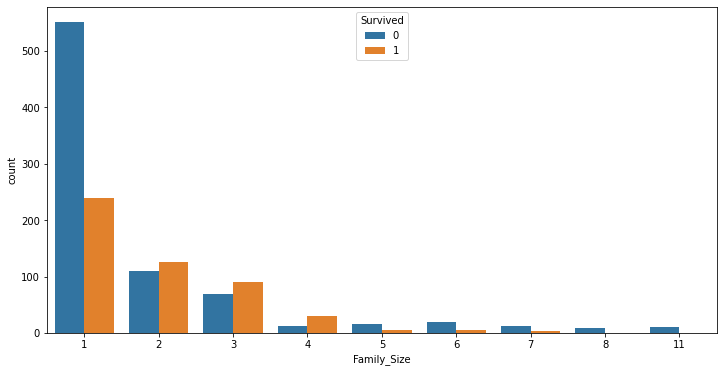

Family_Size_Trans  Survived
0      Large_Family    0.0000
1     Median_Family    0.2381
2     Single_Person    0.3025
3      Small_Family    0.5629

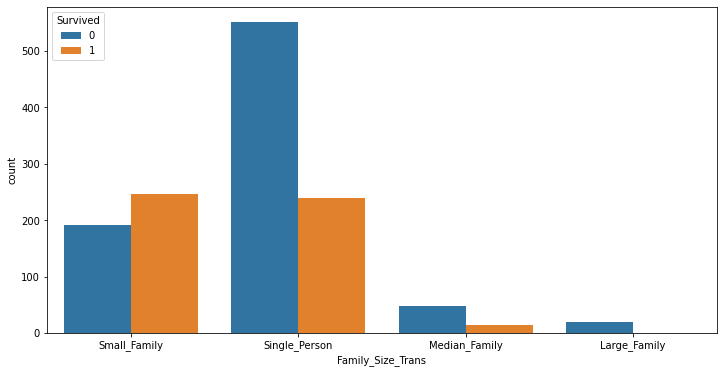

index  PassengerId  Survived  Pclass  \
0         0            1         0       3   
1         1            2         1       1   
2         2            3         1       3   
3         3            4         1       1   
4         4            5         0       3   
...     ...          ...       ...     ...   
1304    413         1305         0       3   
1305    414         1306         1       1   
1306    415         1307         0       3   
1307    416         1308         0       3   
1308    417         1309         1       3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                                 ...     ...   ...    ...   
1304                                 Spector, Mr. Woolf    male   NaN      0   
1305                       Oliva y Ocana, Dona. Fermina  female  39.0      0   
1306                       Saether, Mr. Simon Sivertsen    male  38.5      0   
1307                                Ware, Mr. Frederick    male   NaN      0   
1308                           Peter, Master. Michael J    male   NaN      1   

      Parch              Ticket  ...  Fare_4 Fare_5 Fare_6  \
0         0           A/5 21171  ...       0      0      0   
1         0            PC 17599  ...       3      4      5   
2         0    STON/O2. 3101282  ...       1      1      1   
3         0              113803  ...       3      4      4   
4         0              373450  ...       1      1      1   
...     ...                 ...  ...     ...    ...    ...   
1304      0           A.5. 3236  ...       1      1      1   
1305      0            PC 17758  ...       3      4      5   
1306      0  SOTON/O.Q. 3101262  ...       0      0      0   
1307      0              359309  ...       1      1      1   
1308      1                2668  ...       2      3      3   

      Connected_Survival   Title  Family_Size_Trans  Large_Family  \
0                    0.5      Mr       Small_Family             0   
1                    1.0     Mrs       Small_Family             0   
2                    0.5    Miss      Single_Person             0   
3                    1.0     Mrs       Small_Family             0   
4                    0.5      Mr      Single_Person             0   
...                  ...     ...                ...           ...   
1304                 0.5      Mr      Single_Person             0   
1305                 1.0   Royal      Single_Person             0   
1306                 0.5      Mr      Single_Person             0   
1307                 0.5      Mr      Single_Person             0   
1308                 1.0  Master       Small_Family             0   

      Median_Family  Single_Person Small_Family  
0                 0              0            1  
1                 0              0            1  
2                 0              1            0  
3                 0              0            1  
4                 0              1            0  
...             ...            ...          ...  
1304              0              1            0  
1305              0              1            0  
1306              0              1            0  
1307              0              1            0  
1308              0              0            1  

[1309 rows x 25 columns]

In [25]:
data['Family_Size'] = data['SibSp']+data['Parch']+1

data['Family_Size_Trans'] = ''
for f_size in data['Family_Size'].unique():
    if f_size == 1:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Single_Person'
    elif f_size >= 2 and f_size <= 4:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Small_Family'
    elif f_size > 4 and f_size < 8:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Median_Family'
    elif f_size >= 8:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Large_Family'
        
display(data[['Family_Size', 'Survived']].groupby(['Family_Size'], as_index=False).mean().round(4))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
sns.countplot(x=data['Family_Size'], hue=data['Survived'], ax=ax1)
plt.show()

display(data[['Family_Size_Trans', 'Survived']].groupby(['Family_Size_Trans'], as_index=False).mean().round(4))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
sns.countplot(x=data['Family_Size_Trans'], hue=data['Survived'], ax=ax1)
plt.show()

pd.concat([data, pd.get_dummies(data['Family_Size_Trans'])], axis=1)  

## Ticket Count

Ticket_Trans  Survived
0             1    0.2721
1             2    0.5076
2             3    0.6259
3             4    0.7031
4             5    0.3714
5             6    0.2917
6             7    0.2571
7             8    0.3750
8            11    0.0000

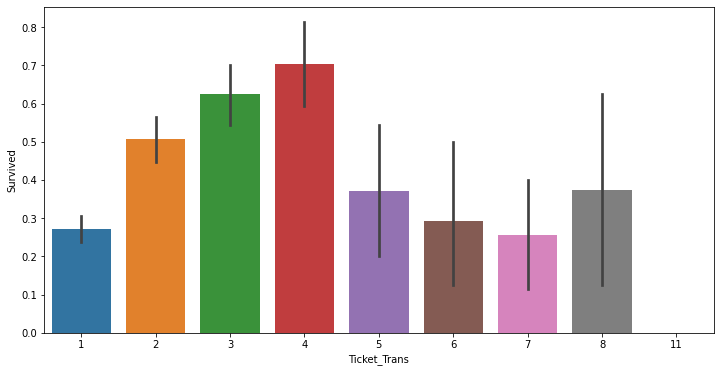

Ticket_Trans  Survived
0     Ticket_1    0.2721
1    Ticket_11    0.0000
2   Ticket_2_4    0.5705
3   Ticket_5_8    0.3182

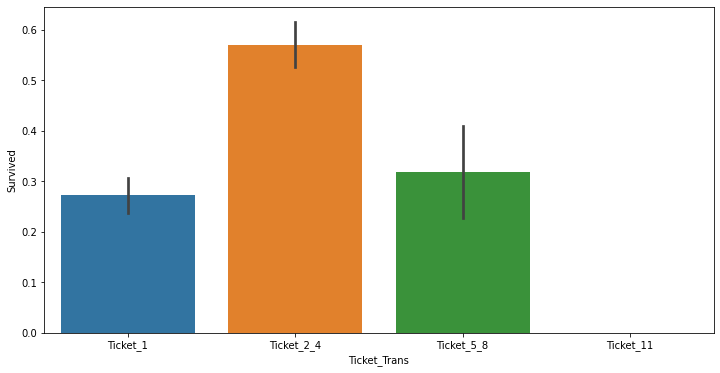

index  PassengerId  Survived  Pclass  \
0         0            1         0       3   
1         1            2         1       1   
2         2            3         1       3   
3         3            4         1       1   
4         4            5         0       3   
...     ...          ...       ...     ...   
1304    413         1305         0       3   
1305    414         1306         1       1   
1306    415         1307         0       3   
1307    416         1308         0       3   
1308    417         1309         1       3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                                 ...     ...   ...    ...   
1304                                 Spector, Mr. Woolf    male   NaN      0   
1305                       Oliva y Ocana, Dona. Fermina  female  39.0      0   
1306                       Saether, Mr. Simon Sivertsen    male  38.5      0   
1307                                Ware, Mr. Frederick    male   NaN      0   
1308                           Peter, Master. Michael J    male   NaN      1   

      Parch              Ticket  ...  Fare_5 Fare_6 Connected_Survival  \
0         0           A/5 21171  ...       0      0                0.5   
1         0            PC 17599  ...       4      5                1.0   
2         0    STON/O2. 3101282  ...       1      1                0.5   
3         0              113803  ...       4      4                1.0   
4         0              373450  ...       1      1                0.5   
...     ...                 ...  ...     ...    ...                ...   
1304      0           A.5. 3236  ...       1      1                0.5   
1305      0            PC 17758  ...       4      5                1.0   
1306      0  SOTON/O.Q. 3101262  ...       0      0                0.5   
1307      0              359309  ...       1      1                0.5   
1308      1                2668  ...       3      3                1.0   

       Title  Family_Size_Trans  Ticket_Trans  Ticket_1  Ticket_11  \
0         Mr       Small_Family      Ticket_1         1          0   
1        Mrs       Small_Family    Ticket_2_4         0          0   
2       Miss      Single_Person      Ticket_1         1          0   
3        Mrs       Small_Family    Ticket_2_4         0          0   
4         Mr      Single_Person      Ticket_1         1          0   
...      ...                ...           ...       ...        ...   
1304      Mr      Single_Person      Ticket_1         1          0   
1305   Royal      Single_Person    Ticket_2_4         0          0   
1306      Mr      Single_Person      Ticket_1         1          0   
1307      Mr      Single_Person      Ticket_1         1          0   
1308  Master       Small_Family    Ticket_2_4         0          0   

      Ticket_2_4 Ticket_5_8  
0              0          0  
1              1          0  
2              0          0  
3              1          0  
4              0          0  
...          ...        ...  
1304           0          0  
1305           1          0  
1306           0          0  
1307           0          0  
1308           1          0  

[1309 rows x 26 columns]

In [26]:
tic_counts = data['Ticket'].value_counts()
data['Ticket_Trans'] = data['Ticket'].map(tic_counts)
data['Ticket_Trans']

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(data[['Ticket_Trans', 'Survived']].groupby(['Ticket_Trans'], as_index=False).mean().round(4))
sns.barplot(data=data, x='Ticket_Trans', y='Survived', ax=ax1)
plt.show()

for t_trans in data['Ticket_Trans'].unique():
    if t_trans == 1:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_1'
    elif t_trans >= 2 and t_trans <=4:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_2_4'
    elif t_trans >= 5 and t_trans <= 8:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_5_8'
    else:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_11'
        
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
display(data[['Ticket_Trans', 'Survived']].groupby(['Ticket_Trans'], as_index=False).mean().round(4))
sns.barplot(data=data, x='Ticket_Trans', y='Survived', ax=ax1)
plt.show()
pd.concat([data,pd.get_dummies(data['Ticket_Trans'])], axis=1)

# Preprocess

In [27]:
data['Embarked'] = data['Embarked'].fillna('S')
data['Embarked_Label'] = data['Embarked'].map({'C':0, 'Q':1, 'S':2}).astype('int')

data['Pclass'] = data['Pclass'].map({1:'P1', 2:'P2', 3:'P3'})
data = pd.concat([data, pd.get_dummies(data['Pclass'])], axis=1)

data['Fare_4'] = pd.qcut(data['Fare'], 4).values
le = LabelEncoder()
data['Fare_4'] = le.fit_transform(data['Fare_4'])
data['Fare_5'] = pd.qcut(data['Fare'], 5).values
le = LabelEncoder()
data['Fare_5'] = LabelEncoder().fit_transform(data['Fare_5'])
data['Fare_6'] = pd.qcut(data['Fare'], 6).values
le = LabelEncoder()
data['Fare_6'] = LabelEncoder().fit_transform(data['Fare_6'])

data['Connected_Survival'] = 0.5
unique, counts = np.unique(data['Ticket'].values, return_counts=True)
for ticket, cou in zip(unique, counts):
    if cou > 1:
        s_max = data.loc[data['Ticket'] == ticket, 'Survived'].max()
        s_min = data.loc[data['Ticket'] == ticket, 'Survived'].min()
        if s_max == 1.0:
            data.loc[data['Ticket'] == ticket, 'Connected_Survival'] = 1.0
        elif s_min == 0.0:
            data.loc[data['Ticket'] == ticket, 'Connected_Survival'] = 0.0

data['Sex_Label'] = data['Sex'].map({'male':0, 'female':1}).astype('int')

data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Rev'], 'Rare')
data['Title'] = data['Title'].replace(['Jonkheer', 'Sir', 'Lady', 'Don', 'Countess', 'Dona'], 'Royal')
data['Title'] = data['Title'].replace(['Mlle', 'Mme', 'Ms'], 'Miss')
# data['Title'] = data['Title'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Rare':4, 'Royal':5}).astype('int')
data = pd.concat([data, pd.get_dummies(data['Title'])], axis=1)

data['Age_Trans'] = data['Age']
Age_Median = data.groupby('Title')['Age'].median()
# print('Age_Median:', Age_Median)
for i in range(6):
    data.loc[(data['Age'].isnull()) & (data['Title'] == i), 'Age_Trans'] = Age_Median[i]
data['Age_Minimum'] = (data['Age_Trans']< 16.0) *1

data['Family_Size'] = data['SibSp']+data['Parch']+1
data['Family_Size_Trans'] = ''
for f_size in data['Family_Size'].unique():
    if f_size == 1:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Single_Person'
    elif f_size >= 2 and f_size <= 4:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Small_Family'
    elif f_size > 4 and f_size < 8:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Median_Family'
    elif f_size >= 8:
        data.loc[data['Family_Size']==f_size, 'Family_Size_Trans'] = 'Large_Family'
# data['Family_Size_Trans'] = data['Family_Size_Trans'].map({'Single_Person':0, 'Small_Family':1, 'Median_Family':2, 'Large_Family':3}).astype('int')
data = pd.concat([data, pd.get_dummies(data['Family_Size_Trans'])], axis=1)      
        
tic_counts = data['Ticket'].value_counts()
data['Ticket_Trans'] = data['Ticket'].map(tic_counts)
print('tic_counts:', tic_counts)

for t_trans in data['Ticket_Trans'].unique():
    if t_trans == 1:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_1'
    elif t_trans >= 2 and t_trans <=4:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_2_4'
    elif t_trans >= 5 and t_trans <= 8:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_5_8'
    else:
        data.loc[data['Ticket_Trans']==t_trans, 'Ticket_Trans'] = 'Ticket_11'
# data['Ticket_Trans'] = data['Ticket_Trans'].map({'Ticket_1':0, 'Ticket_2_4':1, 'Ticket_5_8':2, 'Ticket_11':3}).astype('int')
data = pd.concat([data, pd.get_dummies(data['Ticket_Trans'])], axis=1) 

display(data)
    
    
train_data['Age_Minimum'] = data['Age_Minimum'].values[:len(train_data)]

# train_data['Fare_4'] = data['Fare_4'].values[:len(train_data)]
train_data['Fare_5'] = data['Fare_5'].values[:len(train_data)]
# train_data['Fare_6'] = data['Fare_6'].values[:len(train_data)]

train_data['Sex_Label'] = data['Sex_Label'].values[:len(train_data)]

train_data['Embarked_Label'] = data['Embarked_Label'].values[:len(train_data)]

train_data['Connected_Survival'] = data['Connected_Survival'].values[:len(train_data)]

train_data['P1'] = data['P1'].values[:len(train_data)]
train_data['P2'] = data['P2'].values[:len(train_data)]
train_data['P3'] = data['P3'].values[:len(train_data)]

# train_data['Ticket_Trans'] = data['Ticket_Trans'].values[:len(train_data)]
train_data['Ticket_1'] = data['Ticket_1'].values[:len(train_data)]
train_data['Ticket_2_4'] = data['Ticket_2_4'].values[:len(train_data)]
train_data['Ticket_5_8'] = data['Ticket_5_8'].values[:len(train_data)]
train_data['Ticket_11'] = data['Ticket_11'].values[:len(train_data)]

# train_data['Title'] = data['Title'].values[:len(train_data)]
train_data['Master'] = data['Master'].values[:len(train_data)]
train_data['Miss'] = data['Miss'].values[:len(train_data)]
train_data['Mr'] = data['Mr'].values[:len(train_data)]
train_data['Mrs'] = data['Mrs'].values[:len(train_data)]
train_data['Rare'] = data['Rare'].values[:len(train_data)]
train_data['Royal'] = data['Royal'].values[:len(train_data)] 

# train_data['Family_Size'] = data['Family_Size'].values[:len(train_data)]
# train_data['Family_Size_Trans'] = data['Family_Size_Trans'].values[:len(train_data)]
train_data['Single_Person'] = data['Single_Person'].values[:len(train_data)]
train_data['Small_Family'] = data['Small_Family'].values[:len(train_data)]
train_data['Median_Family'] = data['Median_Family'].values[:len(train_data)]
train_data['Large_Family'] = data['Large_Family'].values[:len(train_data)]
    
print(train_data.info())


test_data['Age_Minimum'] = data['Age_Minimum'].values[len(train_data):]

# test_data['Fare_4'] = data['Fare_4'].values[len(train_data):]
test_data['Fare_5'] = data['Fare_5'].values[len(train_data):]
# test_data['Fare_6'] = data['Fare_6'].values[len(train_data):]

test_data['Sex_Label'] = data['Sex_Label'].values[len(train_data):]

test_data['Embarked_Label'] = data['Embarked_Label'].values[len(train_data):]

test_data['Connected_Survival'] = data['Connected_Survival'].values[len(train_data):]

test_data['P1'] = data['P1'].values[len(train_data):]
test_data['P2'] = data['P2'].values[len(train_data):]
test_data['P3'] = data['P3'].values[len(train_data):]

# test_data['Ticket_Trans'] = data['Ticket_Trans'].values[len(train_data):]
test_data['Ticket_1'] = data['Ticket_1'].values[len(train_data):]
test_data['Ticket_2_4'] = data['Ticket_2_4'].values[len(train_data):]
test_data['Ticket_5_8'] = data['Ticket_5_8'].values[len(train_data):]
test_data['Ticket_11'] = data['Ticket_11'].values[len(train_data):]

# test_data['Title'] = data['Title'].values[len(train_data):]
test_data['Master'] = data['Master'].values[len(train_data):]
test_data['Miss'] = data['Miss'].values[len(train_data):]
test_data['Mr'] = data['Mr'].values[len(train_data):]
test_data['Mrs'] = data['Mrs'].values[len(train_data):]
test_data['Rare'] = data['Rare'].values[len(train_data):]
test_data['Royal'] = data['Royal'].values[len(train_data):] 

# test_data['Family_Size'] = data['Family_Size'].values[len(train_data):]
# test_data['Family_Size_Trans'] = data['Family_Size_Trans'].values[len(train_data):]
test_data['Single_Person'] = data['Single_Person'].values[len(train_data):]
test_data['Small_Family'] = data['Small_Family'].values[len(train_data):]
test_data['Median_Family'] = data['Median_Family'].values[len(train_data):]
test_data['Large_Family'] = data['Large_Family'].values[len(train_data):]

print(test_data.info())
display(train_data)
display(test_data)

tic_counts: CA. 2343             11
CA 2144               8
1601                  8
3101295               7
S.O.C. 14879          7
                     ..
349240                1
248698                1
STON/O2. 3101270      1
SOTON/O.Q. 392087     1
28206                 1
Name: Ticket, Length: 929, dtype: int64


index  PassengerId  Survived Pclass  \
0         0            1         0     P3   
1         1            2         1     P1   
2         2            3         1     P3   
3         3            4         1     P1   
4         4            5         0     P3   
...     ...          ...       ...    ...   
1304    413         1305         0     P3   
1305    414         1306         1     P1   
1306    415         1307         0     P3   
1307    416         1308         0     P3   
1308    417         1309         1     P3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                                 ...     ...   ...    ...   
1304                                 Spector, Mr. Woolf    male   NaN      0   
1305                       Oliva y Ocana, Dona. Fermina  female  39.0      0   
1306                       Saether, Mr. Simon Sivertsen    male  38.5      0   
1307                                Ware, Mr. Frederick    male   NaN      0   
1308                           Peter, Master. Michael J    male   NaN      1   

      Parch              Ticket  ...  Age_Trans Age_Minimum Large_Family  \
0         0           A/5 21171  ...       22.0           0            0   
1         0            PC 17599  ...       38.0           0            0   
2         0    STON/O2. 3101282  ...       26.0           0            0   
3         0              113803  ...       35.0           0            0   
4         0              373450  ...       35.0           0            0   
...     ...                 ...  ...        ...         ...          ...   
1304      0           A.5. 3236  ...        NaN           0            0   
1305      0            PC 17758  ...       39.0           0            0   
1306      0  SOTON/O.Q. 3101262  ...       38.5           0            0   
1307      0              359309  ...        NaN           0            0   
1308      1                2668  ...        NaN           0            0   

      Median_Family  Single_Person  Small_Family  Ticket_1  Ticket_11  \
0                 0              0             1         1          0   
1                 0              0             1         0          0   
2                 0              1             0         1          0   
3                 0              0             1         0          0   
4                 0              1             0         1          0   
...             ...            ...           ...       ...        ...   
1304              0              1             0         1          0   
1305              0              1             0         0          0   
1306              0              1             0         1          0   
1307              0              1             0         1          0   
1308              0              0             1         0          0   

      Ticket_2_4 Ticket_5_8  
0              0          0  
1              1          0  
2              0          0  
3              1          0  
4              0          0  
...          ...        ...  
1304           0          0  
1305           1          0  
1306           0          0  
1307           0          0  
1308           1          0  

[1309 rows x 43 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Survived            891 non-null    int64  
 2   Pclass              891 non-null    int64  
 3   Name                891 non-null    object 
 4   Sex                 891 non-null    object 
 5   Age                 714 non-null    float64
 6   SibSp               891 non-null    int64  
 7   Parch               891 non-null    int64  
 8   Ticket              891 non-null    object 
 9   Fare                891 non-null    float64
 10  Cabin               204 non-null    object 
 11  Embarked            889 non-null    object 
 12  Age_Minimum         891 non-null    int64  
 13  Fare_5              891 non-null    int64  
 14  Sex_Label           891 non-null    int64  
 15  Embarked_Label      891 non-null    int64  
 16  Connecte

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare  ... Master Miss  Mr  Mrs  Rare  Royal  \
0        0         A/5 21171   7.2500  ...      0    0   1    0     0      0   
1        0          PC 17599  71.2833  ...      0    0   0    1     0      0   
2        0  STON/O2. 3101282   7.9250  ...      0    1   0    0     0      0   
3        0            113803  53.1000  ...      0    0   0    1     0      0   
4        0            373450   8.0500  ...      0    0   1    0     0      0   
..     ...               ...      ...  ...    ...  ...  ..  ...   ...    ...   
886      0            211536  13.0000  ...      0    0   0    0     1      0   
887      0            112053  30.0000  ...      0    1   0    0     0      0   
888      2        W./C. 6607  23.4500  ...      0    1   0    0     0      0   
889      0            111369  30.0000  ...      0    0   1    0     0      0   
890      0            370376   7.7500  ...      0    0   1    0     0      0   

     Single_Person  Small_Family  Median_Family  Large_Family  
0                0             1              0             0  
1                0             1              0             0  
2                1             0              0             0  
3                0             1              0             0  
4                1             0              0             0  
..             ...           ...            ...           ...  
886              1             0              0             0  
887              1             0              0             0  
888              0             1              0             0  
889              1             0              0             0  
890              1             0              0             0  

[891 rows x 34 columns]

PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin  ...  \
0      male  34.5      0      0              330911    7.8292   NaN  ...   
1    female  47.0      1      0              363272    7.0000   NaN  ...   
2      male  62.0      0      0              240276    9.6875   NaN  ...   
3      male  27.0      0      0              315154    8.6625   NaN  ...   
4    female  22.0      1      1             3101298   12.2875   NaN  ...   
..      ...   ...    ...    ...                 ...       ...   ...  ...   
413    male   NaN      0      0           A.5. 3236    8.0500   NaN  ...   
414  female  39.0      0      0            PC 17758  108.9000  C105  ...   
415    male  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN  ...   
416    male   NaN      0      0              359309    8.0500   NaN  ...   
417    male   NaN      1      1                2668   22.3583   NaN  ...   

    Master  Miss  Mr  Mrs  Rare  Royal  Single_Person  Small_Family  \
0        0     0   1    0     0      0              1             0   
1        0     0   0    1     0      0              0             1   
2        0     0   1    0     0      0              1             0   
3        0     0   1    0     0      0              1             0   
4        0     0   0    1     0      0              0             1   
..     ...   ...  ..  ...   ...    ...            ...           ...   
413      0     0   1    0     0      0              1             0   
414      0     0   0    0     0      1              1             0   
415      0     0   1    0     0      0              1             0   
416      0     0   1    0     0      0              1             0   
417      1     0   0    0     0      0              0             1   

     Median_Family  Large_Family  
0                0             0  
1                0             0  
2                0             0  
3                0             0  
4                0             0  
..             ...           ...  
413              0             0  
414              0             0  
415              0             0  
416              0             0  
417              0             0  

[418 rows x 34 columns]

[[0. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]] (891, 21)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]] (418, 21)


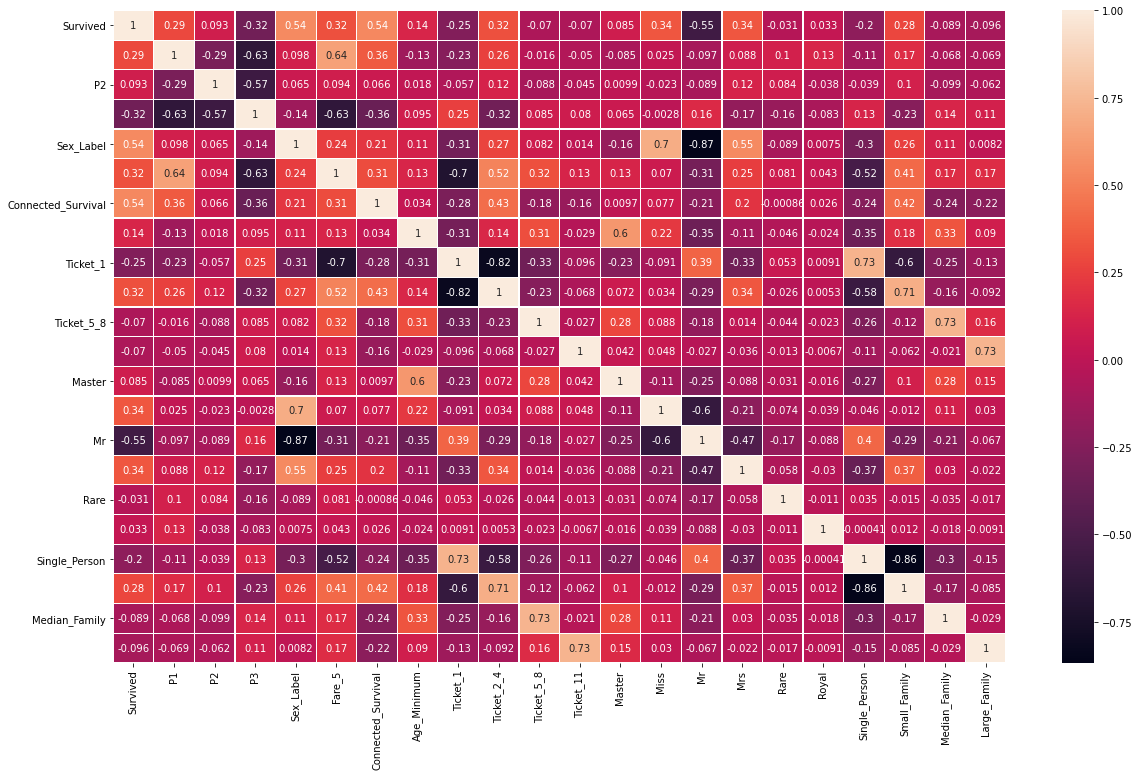

In [35]:
keys = ['P1', 'P2', 'P3', 'Sex_Label', 'Fare_5', 'Connected_Survival', 
          'Age_Minimum', 'Ticket_1', 'Ticket_2_4', 'Ticket_5_8', 
          'Ticket_11', 'Master', 'Miss', 'Mr', 'Mrs', 'Rare', 
          'Royal', 'Single_Person', 'Small_Family', 'Median_Family', 'Large_Family']
# train_x = train_data[['Pclass', 'Sex_Label', 'Age_4', 'Fare_5', 'Embarked_Label', 'Family_Size', 'Ticket_Transform']]
# train_x = train_data[['Pclass', 'Sex_Label', 'Fare_5', 'Connected_Survival', 'Age_Minimum', 'Title', 'Ticket_Trans', 'Family_Size_Trans']].to_numpy()
# train_x = train_data[['Pclass', 'Sex_Label', 'Fare_5', 'Connected_Survival', 'Age_Minimum', 'Family_Size_Trans']].to_numpy()
# keys = ['Pclass', 'Sex_Label', 'Fare_5', 'Connected_Survival', 'Age_Minimum']
# train_x = train_data[['P1', 'P2', 'P3', 'Sex_Label', 'Fare_5', 'Connected_Survival', 
#                       'Age_Minimum', 'Ticket_1', 'Ticket_2_4', 'Ticket_5_8', 
#                       'Ticket_11', 'Master', 'Miss', 'Mr', 'Mrs', 'Rare', 
#                       'Royal']].to_numpy()
train_x = train_data[keys].to_numpy()
train_y = train_data['Survived'].to_numpy()

test_x = test_data[keys].to_numpy()

print(train_x, train_x.shape)
print(test_x, test_x.shape)

sns.heatmap(train_data[['Survived']+keys].corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [29]:
report = ProfileReport(train_data)
report

Summarize dataset:   0%|          | 0/47 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

[ True False  True  True  True  True  True  True  True False False False
  True  True  True False False  True  True False False]
[[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 1. 0. 1.]
 [0. 1. 1. ... 0. 1. 0.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]] (891, 13)
[[0. 1. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]] (418, 13)


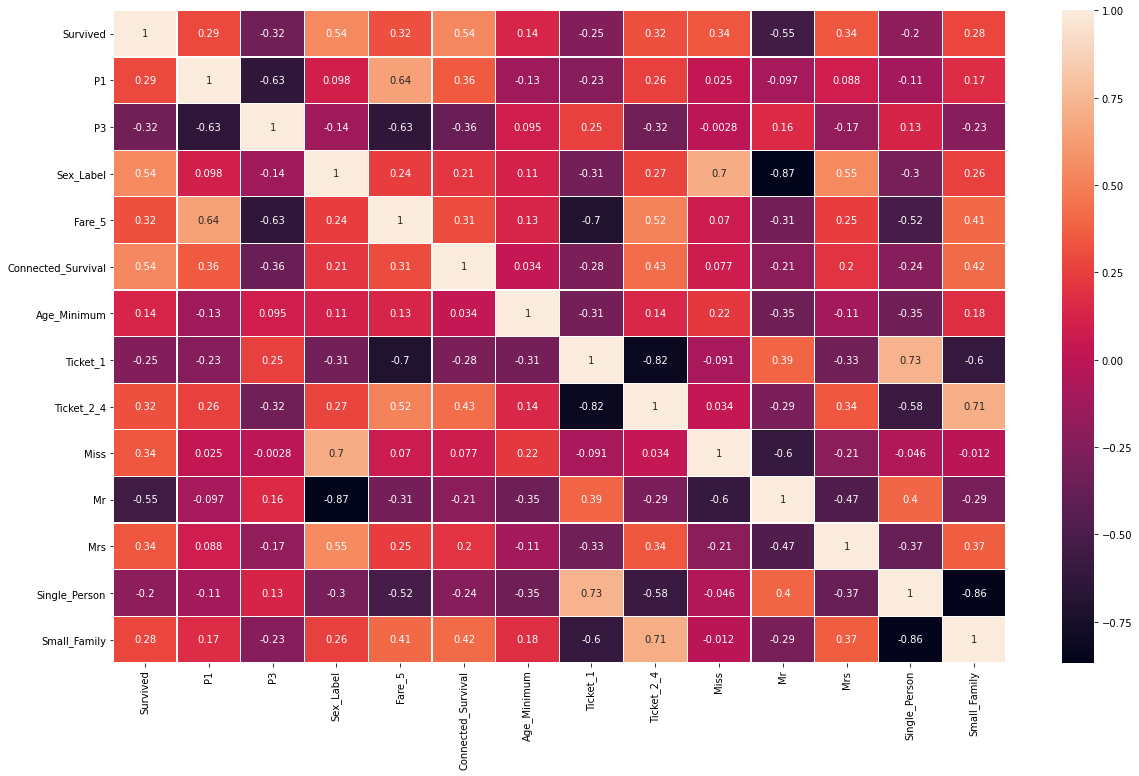

In [31]:
_, p_value = chi2(train_x, train_y)
print(p_value<0.001)
train_x = train_x[:, p_value<0.001]
test_x = test_x[:, p_value<0.001]
print(train_x, train_x.shape)
print(test_x, test_x.shape)
keys = np.array(keys)

sns.heatmap(train_data[['Survived']+keys[p_value<0.001].tolist()].corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
print(pca.fit_transform(train_x).shape)
print(pca.transform(test_x).shape)
print(pca.n_components_)
print(pca.explained_variance_ratio_)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

(891, 8)
(418, 8)
8
[0.55409179 0.12336823 0.08457568 0.06538165 0.0461224  0.03251469
 0.02575311 0.01967958]


In [86]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=168)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True)
callbacks = [earlystop, modelcheckpoint]

acc_li = []
epoch_li = []
for train_idx, val_idx in kfold.split(train_x, train_y):
    inputs = tf.keras.Input(shape=(8,))
    x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adamax(),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    train_history = model.fit(x=train_x[train_idx], 
                              y=train_y[train_idx], 
                              verbose=0, 
                              epochs=1000, 
                              batch_size=64,
                              validation_data=(train_x[val_idx], train_y[val_idx]),
                              shuffle=True,
                              callbacks=callbacks)
    acc = max(train_history.history['val_accuracy'])*100
    epoch = len(train_history.history['val_loss'])
    print('DNN Epochs: {:d}'.format(epoch))
    print('DNN Max Val Accuracy: {:.2f}%'.format(acc))
    print('DNN Min Val Loss: {:.4f}\n'.format(min(train_history.history['val_loss'])))
    acc_li.append(acc)
    epoch_li.append(epoch)

print('DNN Average Epochs: {:d}'.format(round(sum(epoch_li)/len(epoch_li))))
print('DNN : {:.2f}%'.format(sum(acc_li)/len(acc_li)))

svc = SVC(probability=True)
rfc = RandomForestClassifier(random_state=168, n_estimators=250, bootstrap=False)
etc = ExtraTreeClassifier()
gbc = GradientBoostingClassifier()
lr = LogisticRegression(random_state=168)

svc_cv = cross_validate(svc, train_x, train_y, cv=kfold)
print('SVC: {:.2f}%'.format(svc_cv['test_score'].mean()*100))

rfc_cv = cross_validate(rfc, train_x, train_y, cv=kfold)
print('RFC: {:.2f}%'.format(rfc_cv['test_score'].mean()*100))

etc_cv = cross_validate(etc, train_x, train_y, cv=kfold)
print('ETC: {:.2f}%'.format(etc_cv['test_score'].mean()*100))

gbc_cv = cross_validate(gbc, train_x, train_y, cv=kfold)
print('GBC: {:.2f}%'.format(gbc_cv['test_score'].mean()*100))

lr_cv = cross_validate(lr, train_x, train_y, cv=kfold)
print('LR : {:.2f}%\n'.format(lr_cv['test_score'].mean()*100))

DNN Epochs: 145
DNN Max Val Accuracy: 92.22%
DNN Min Val Loss: 0.3980

DNN Epochs: 163
DNN Max Val Accuracy: 86.52%
DNN Min Val Loss: 0.4107

DNN Epochs: 180
DNN Max Val Accuracy: 91.01%
DNN Min Val Loss: 0.3271

DNN Epochs: 166
DNN Max Val Accuracy: 85.39%
DNN Min Val Loss: 0.4874

DNN Epochs: 140
DNN Max Val Accuracy: 87.64%
DNN Min Val Loss: 0.4605

DNN Epochs: 160
DNN Max Val Accuracy: 83.15%
DNN Min Val Loss: 0.5192

DNN Epochs: 215
DNN Max Val Accuracy: 88.76%
DNN Min Val Loss: 0.3298

DNN Epochs: 154
DNN Max Val Accuracy: 83.15%
DNN Min Val Loss: 0.5139

DNN Epochs: 120
DNN Max Val Accuracy: 85.39%
DNN Min Val Loss: 0.5332

DNN Epochs: 161
DNN Max Val Accuracy: 85.39%
DNN Min Val Loss: 0.5178

DNN Average Epochs: 160
DNN : 86.86%
SVC: 86.19%
RFC: 84.17%
ETC: 83.38%
GBC: 83.83%
LR : 84.39%



### 7
DNN Epochs: 45<br>
DNN : 88.10%<br>
SVC: 86.30%<br>
RFC: 84.84%<br>
ETC: 84.17%<br>
GBC: 84.84%<br>
LR : 86.86%

---

## 6
DNN Epochs: 44<br>
DNN : 87.99%<br>
SVC: 86.53%<br>
RFC: 86.19%<br>
ETC: 85.96%<br>
GBC: 84.95%<br>
LR : 86.19%

## 6
DNN Epochs: 44<br>
DNN : 87.21%<br>
SVC: 86.19%<br>
RFC: 84.73%<br>
ETC: 84.50%<br>
GBC: 85.07%<br>
LR : 86.75%<br>

---

## 5
DNN Epochs: 49<br>
DNN : 88.66%<br>
SVC: 86.30%<br>
RFC: 85.51%<br>
ETC: 85.51%<br>
GBC: 84.95%<br>
LR : 84.96%

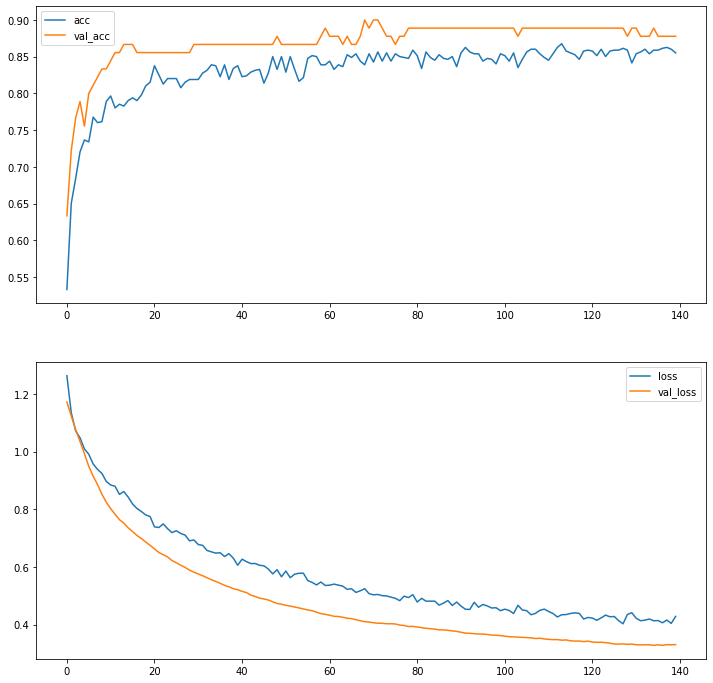

In [88]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,1,2)
ax2 = fig.add_subplot(2,1,1)
ax1.plot(train_history.history['loss'], label='loss')
ax1.plot(train_history.history['val_loss'], label='val_loss')
ax1.legend()
ax2.plot(train_history.history['accuracy'], label='acc')
ax2.plot(train_history.history['val_accuracy'], label='val_acc')
ax2.legend()
plt.show()

In [87]:
svc = SVC(probability=True)
rfc = RandomForestClassifier(random_state=168, n_estimators=250, bootstrap=False)
etc = ExtraTreeClassifier()
gbc = GradientBoostingClassifier()
lr = LogisticRegression(random_state=168)

svc.fit(train_x, train_y)
rfc.fit(train_x, train_y)
etc.fit(train_x, train_y)
gbc.fit(train_x, train_y)
lr.fit(train_x, train_y)
# clf.fit(train_x, train_y)
# print(clf.score(val_x, val_y))
# print(clf.oob_score_)

# -----------------------------------------

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='feature_8.h5', save_best_only=True)
callbacks = [earlystop, modelcheckpoint]

inputs = tf.keras.Input(shape=(8,))
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2')(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adamax",
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()

train_history = model.fit(x=train_x, 
                          y=train_y, 
                          verbose=1, 
                          epochs=1000,
                          validation_split=0.1,
                          batch_size=16,
                          shuffle=True,
                          callbacks=callbacks)


Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_172 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_43 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_173 (Dense)            (None, 32)                544       
_________________________________________________________________
batch_normalization_43 (Batc (None, 32)                128       
_________________________________________________________________
dense_174 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_175 (Dense)            (None, 1)                 17 

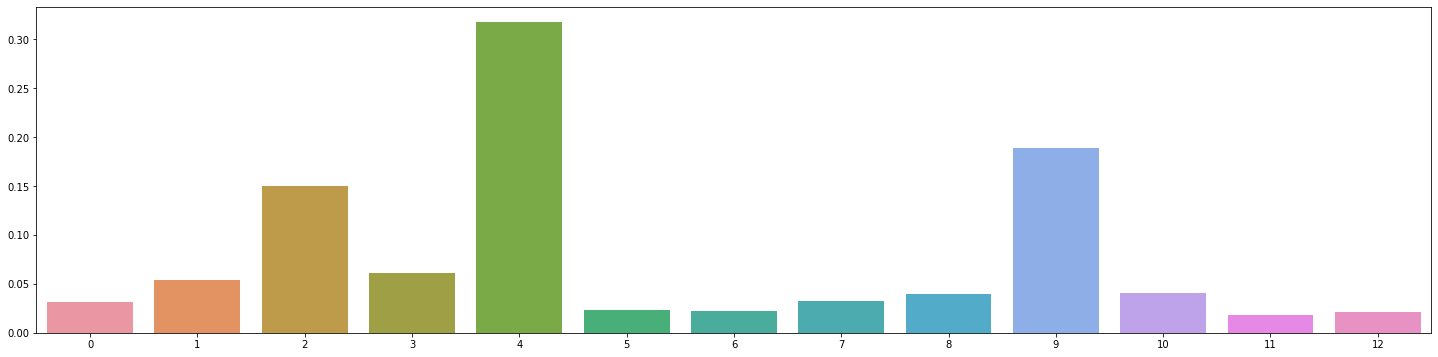

In [68]:
rfc.feature_importances_
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(1,1,1)
sns.barplot(x=[i for i in range(len(train_x[0]))], y=rfc.feature_importances_, ax=ax1)
plt.show()

# Auto ML

In [34]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
callbacks = [earlystop]

clf = ak.StructuredDataClassifier(overwrite=True, max_trials=1000)
clf.fit(train_x, train_y, callbacks=callbacks, validation_data=(test_x, test_data['Survived'].values))
model = clf.export_model()
model.summary()

print(model.predict(test_x)[:10])

Trial 56 Complete [00h 00m 07s]
val_accuracy: 0.8301435112953186

Best val_accuracy So Far: 0.8444976210594177
Total elapsed time: 00h 12m 31s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 8)                 0         
_________________________________________________________________
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense (Dense)                (None, 1024)              9216      
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096   

In [83]:
model.save('automl_8', save_format='tf')


INFO:tensorflow:Assets written to: automl_5/assets


In [33]:
model = load_model('automl_8')

print(test_x.shape)
print(test_data['Survived'].shape)

model.evaluate(test_x, np.expand_dims(test_data['Survived'].values, axis=1))

(418, 8)
(418,)
14/14 [==============================] - 1s 2ms/step - loss: 0.4112 - accuracy: 0.8349


[0.41124871373176575, 0.8349282145500183]

# Predict

In [89]:
def prediction(model, model_type, output_name):
    result = model.predict(test_x)
    print(result[:10])
    
    if model_type == 'softmax':
        result = np.argmax(result, axis=1)
    elif model_type == 'sigmoid':
        result = np.around(result)
        result = result.astype('int8')
# 
#     print(result[:10])
    
    result_csv = pd.read_csv('titanic/gender_submission.csv')
    result_csv['Survived'] = result
    result_csv.to_csv(output_name, index=False)

    return result


def ensemble(models, model_types, output_name):
    result_csv = pd.read_csv('titanic/gender_submission.csv')
    result = np.zeros((len(result_csv), 2))
    
    for model, model_type in zip(models, model_types):
        if model_type == 'softmax':
            result = result+model.predict(test_x)
        elif model_type == 'sigmoid':
            result[:,0] = result[:,0]+(1-model.predict(test_x))[:,0]
            result[:,1] = result[:,1]+model.predict(test_x)[:,0]
        else:
            result = result+model.predict_proba(test_x)
    result = np.argmax(result, axis=1)
    print(result)
    result_csv['Survived'] = result
    result_csv.to_csv(output_name, index=False)

    return

In [91]:
# result_csv = 'titanic/sub_sigmoid_adam.csv'
# result_csv = 'titanic/feature_8.csv'
# model = load_model('feature_8.h5')
# result = prediction(model, 'sigmoid', result_csv)

result_csv = 'titanic/svc.csv'
# result_csv = 'titanic/rfc.csv'
# result_csv = 'titanic/etc.csv'
# result_csv = 'titanic/xgbc.csv'
# result_csv = 'titanic/gbc.csv'
# result_csv = 'titanic/lr.csv'
prediction(svc, 'ml', result_csv)

# output_name = 'titanic/en_dnn_pca.csv'
# adagrad = load_model('best_model_adagrad.h5')
# adam = load_model('best_model_adam.h5')
# adamax = load_model('best_model_adamax.h5')
# nadam = load_model('best_model_nadam.h5')
# rmsprop = load_model('best_model_rmsprop.h5')

# adagrad = load_model('pca_adagrad.h5')
# adam = load_model('pca_adam.h5')
# adamax = load_model('pca_adamax.h5')
# nadam = load_model('pca_nadam.h5')
# rmsprop = load_model('pca_rmsprop.h5')

# result_adagrad = adagrad.predict(test_x)
# result_adam = adam.predict(test_x)
# result_adamax = adamax.predict(test_x)
# result_nadam = nadam.predict(test_x)
# result_rmsprop = rmsprop.predict(test_x)

# result = 0.80382*result_adamax+0.79904*result_nadam+0.7799*result_adagrad+0.79425*result_adam+0.80143*result_rmsprop
# result = np.around(result/3.97844).astype('int8')

# result_csv = pd.read_csv('titanic/gender_submission.csv')
# result_csv['Survived'] = result
# result_csv.to_csv(output_name, index=False)

# ensemble([adagrad, adam, adamax, nadam, rmsprop], ['sigmoid' for i in range(5)], result_csv)

[0 0 0 0 1 0 1 0 1 0]


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [107]:
a = pd.read_csv('titanic/pca_adam.csv')
b = pd.read_csv('titanic/pca_adamax.csv')
c = pd.read_csv('titanic/pca_nadam.csv')


for i in range(len(a)):
    if b.iloc[i]['Survived'] != c.iloc[i]['Survived']:
        print(i, ':', a.iloc[i]['Survived'], b.iloc[i]['Survived'], c.iloc[i]['Survived'])

1 : 0 0 1
131 : 0 1 0
154 : 1 0 1
379 : 1 0 1
